## Tugas Praktikum Signal Processing
##### Harvest Walukow - 164231104

### Load Data

In [1]:
import os
import glob
import fnmatch
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import math
import tensorflow as tf
import kagglehub
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import seaborn as sns

2025-11-07 11:33:17.479285: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762515197.502699    3828 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762515197.509658    3828 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
data_path = kagglehub.dataset_download('abdallahaboelkhair/heartbeat-sound')

In [3]:
train_data = data_path + '/Heartbeat_Sound'
unlabel_data = data_path + '/Heartbeat_Sound/unlabel/'

# path 5 kategori ada yang akan dimodelkan
normal_data = train_data + '/normal/'
murmur_data= train_data + '/murmur/'
extrastole_data = train_data + '/extrastole/'
artifact_data = train_data + '/artifact/'
extrahls_data = train_data + '/extrahls/'

In [4]:
# menghitung jumlah file untuk tiap data training
for i in [normal_data, murmur_data, extrastole_data, artifact_data, extrahls_data]:
  print(f'{os.path.basename(os.path.normpath(i))}: {len(os.listdir(i))}')

normal: 351
murmur: 129
extrastole: 46
artifact: 40
extrahls: 19


In [5]:
# menghitung jumlah file untuk data testing
print(f'unlabel: {len(os.listdir(unlabel_data))}')


unlabel: 247


### EDA

###### Pie Chart Jumlah Data

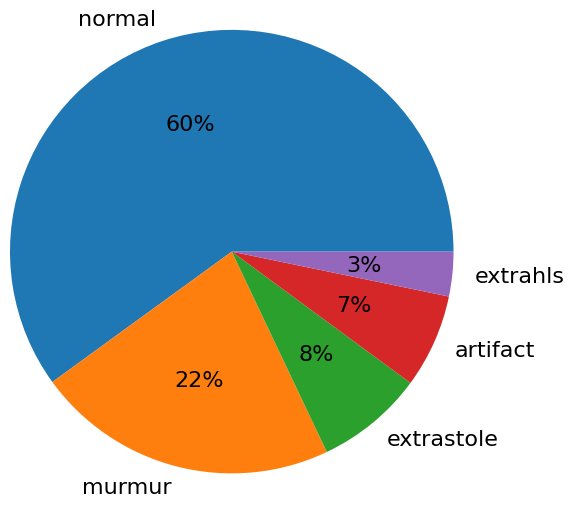

In [6]:
x = np.array([len(os.listdir(normal_data)),
              len(os.listdir(murmur_data)),
              len(os.listdir(extrastole_data)),
              len(os.listdir(artifact_data)),
              len(os.listdir(extrahls_data))])
labels = ['normal', 'murmur', 'extrastole', 'artifact', 'extrahls']
plt.pie(x, labels = labels, autopct = '%.0f%%', radius = 1.5, textprops={'fontsize': 16})
plt.show()

In [7]:
# membuat fungsi-fungsi yang dibutuhkan untuk visualisasi di tiap kelas

def get_random_sample(folder_path, sr=22050):
    files = os.listdir(folder_path)
    random_idx = np.random.randint(0, len(files))
    sample_file = files[random_idx]
    sample_path = folder_path + sample_file
    sample, sample_rate = librosa.load(sample_path, sr=sr)
    return sample, sample_rate, sample_file

def plot_waveform(sample, sr, title="Waveform", figsize=(20, 5)):
    plt.figure(figsize=figsize)
    librosa.display.waveshow(sample, sr=sr)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

def plot_spectrum(sample, sr, title="Spectrum", figsize=(12, 8)):
    fft = np.fft.fft(sample)
    magnitude = np.abs(fft)
    freq = np.linspace(0, sr, len(magnitude))
    half_freq = freq[:int(len(freq)/2)]
    half_magnitude = magnitude[:int(len(freq)/2)]

    plt.figure(figsize=figsize)
    plt.plot(half_freq, half_magnitude)
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    plt.show()

def plot_spectrogram(sample, sr, title="Spectrogram", hop_length=512, n_fft=2048,
                     cmap=None, figsize=(15, 10), print_info=True):
    if print_info:
        hop_length_duration = float(hop_length)/sr
        n_fft_duration = float(n_fft)/sr
        print(f"STFT hop length duration is: {hop_length_duration}s")
        print(f"STFT window duration is: {n_fft_duration}s")

    stft = librosa.stft(sample, n_fft=n_fft, hop_length=hop_length)
    spectrogram = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(spectrogram)

    plt.figure(figsize=figsize)
    librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
    if cmap:
        plt.set_cmap(cmap)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.colorbar()
    plt.show()

def plot_mfcc(sample, sr, title="MFCCs", hop_length=512, n_fft=2048,
              n_mfcc=25, cmap=None, figsize=(15, 10)):
    MFCCs = librosa.feature.mfcc(y=sample, sr=sr, n_fft=n_fft,
                                 hop_length=hop_length, n_mfcc=n_mfcc)

    plt.figure(figsize=figsize)
    librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length)
    if cmap:
        plt.set_cmap(cmap)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("MFCC coefficients")
    plt.colorbar()
    plt.show()

def visualize_class(folder_path, class_name, sr=22050, hop_length=512, n_fft=2048,
                   spectrogram_cmap=None, mfcc_cmap=None, show_audio=True):
    sample, sample_rate, sample_file = get_random_sample(folder_path, sr=sr)

    if show_audio:
        audio_player = ipd.Audio(sample, rate=sample_rate)
        display(audio_player)

    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle(f'{class_name} Sound - Complete Visualization', fontsize=16, fontweight='bold')

    # 1. waveform
    ax1 = axes[0, 0]
    librosa.display.waveshow(sample, sr=sample_rate, ax=ax1)
    ax1.set_title('Waveform', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude')

    # 2. spectrum
    ax2 = axes[0, 1]
    fft = np.fft.fft(sample)
    magnitude = np.abs(fft)
    freq = np.linspace(0, sample_rate, len(magnitude))
    half_freq = freq[:int(len(freq)/2)]
    half_magnitude = magnitude[:int(len(freq)/2)]
    ax2.plot(half_freq, half_magnitude)
    ax2.set_title('Frequency Spectrum', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Magnitude')
    ax2.grid(True, alpha=0.3)

    # 3. spectrogram
    ax3 = axes[1, 0]
    stft = librosa.stft(sample, n_fft=n_fft, hop_length=hop_length)
    spectrogram = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(spectrogram)
    img1 = librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length,
                                    ax=ax3, x_axis='time', y_axis='hz')
    if spectrogram_cmap:
        img1.set_cmap(spectrogram_cmap)
    ax3.set_title('Spectrogram', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Frequency (Hz)')
    plt.colorbar(img1, ax=ax3, format='%+2.0f dB')

    # 4. MFCCs
    ax4 = axes[1, 1]
    MFCCs = librosa.feature.mfcc(y=sample, sr=sample_rate, n_fft=n_fft,
                                 hop_length=hop_length, n_mfcc=25)
    img2 = librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length,
                                     ax=ax4, x_axis='time')
    if mfcc_cmap:
        img2.set_cmap(mfcc_cmap)
    ax4.set_title('MFCCs', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('MFCC Coefficients')
    plt.colorbar(img2, ax=ax4)

    plt.tight_layout()
    plt.show()

    # STFT
    hop_length_duration = float(hop_length)/sample_rate
    n_fft_duration = float(n_fft)/sample_rate
    print(f"STFT hop length duration: {hop_length_duration:.4f}s")
    print(f"STFT window duration: {n_fft_duration:.4f}s")

    return sample, sample_rate


###### Normal

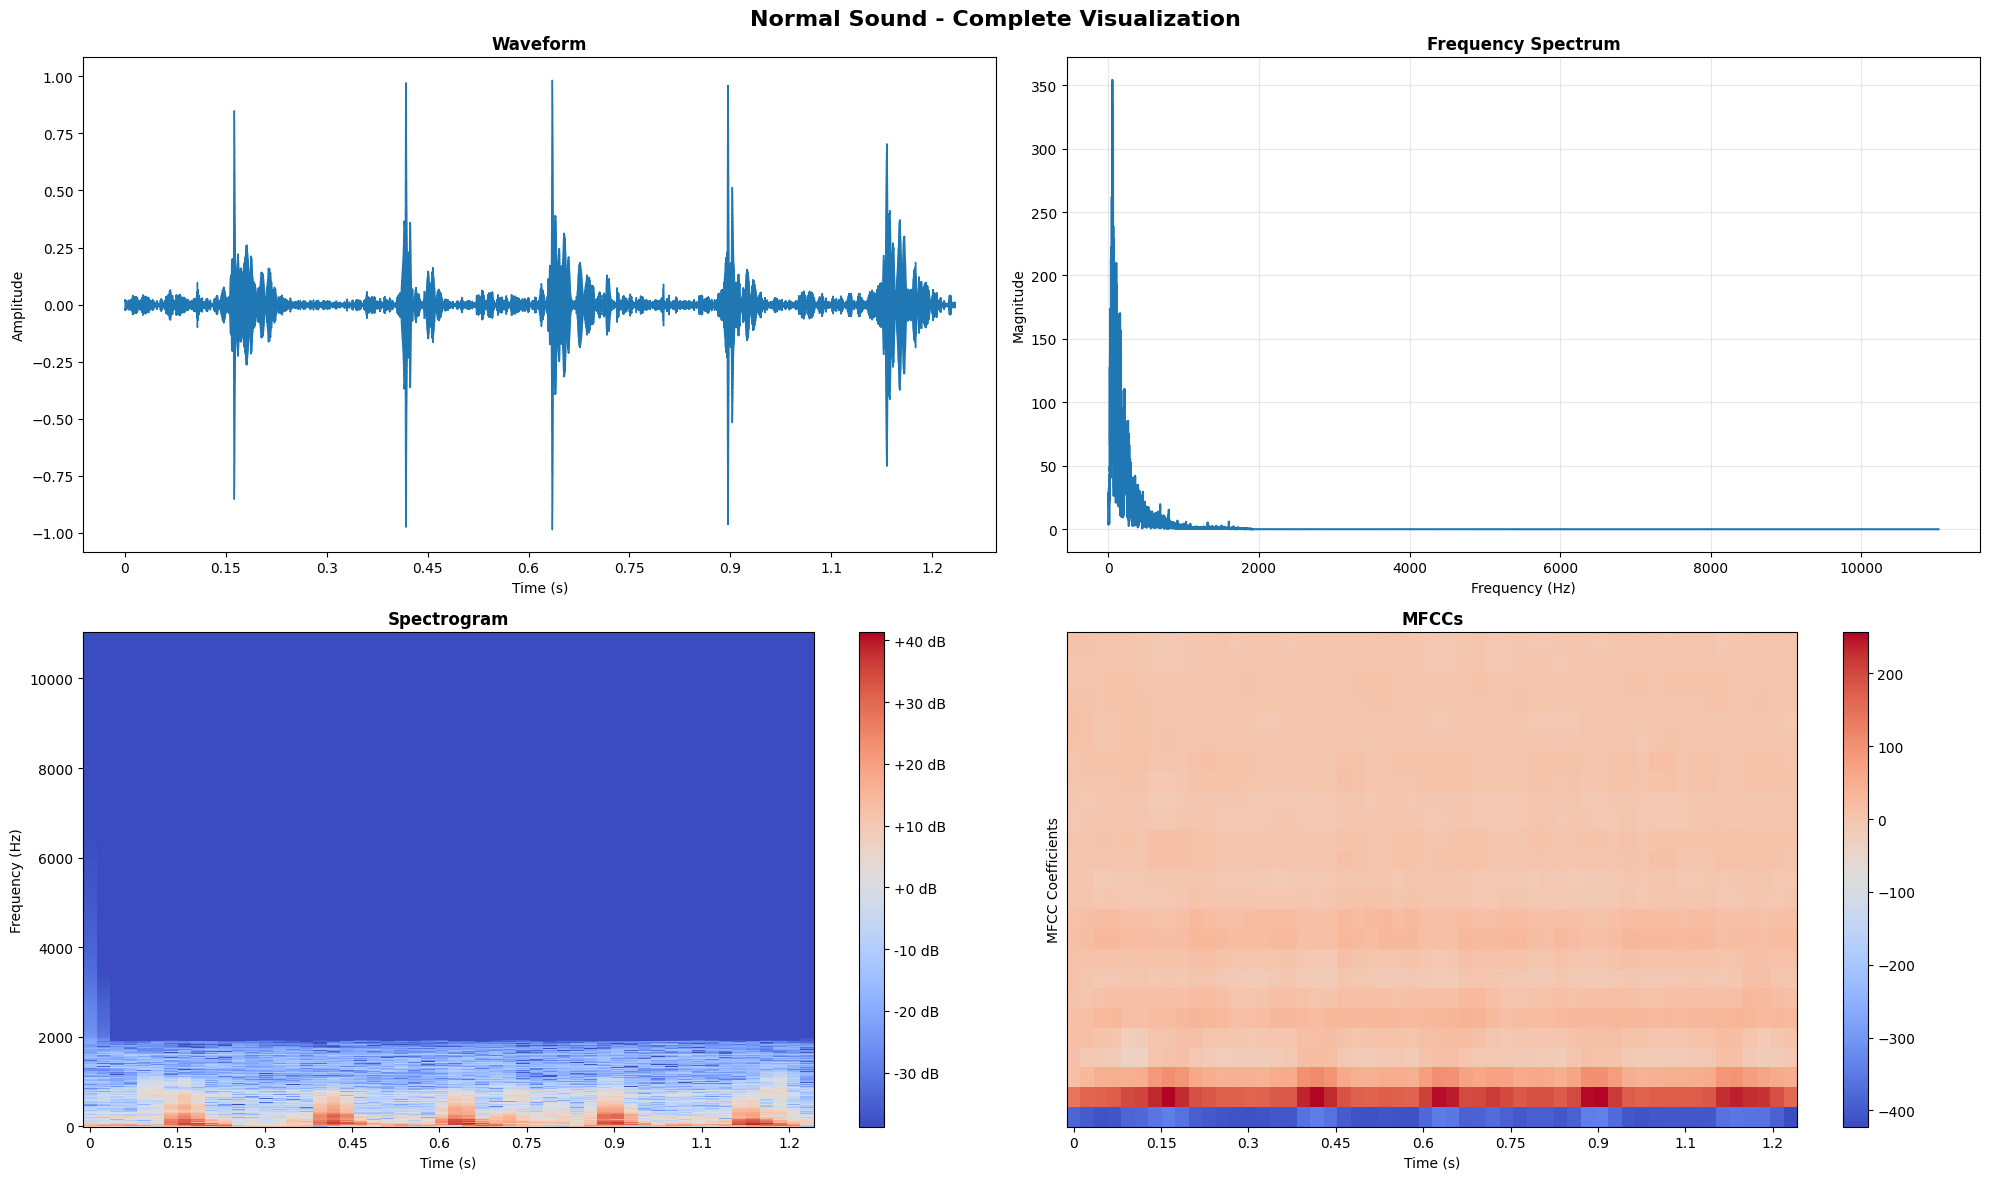

STFT hop length duration: 0.0232s
STFT window duration: 0.0929s


In [8]:
normal_sample, normal_sr = visualize_class(normal_data, "Normal")

###### Murmur

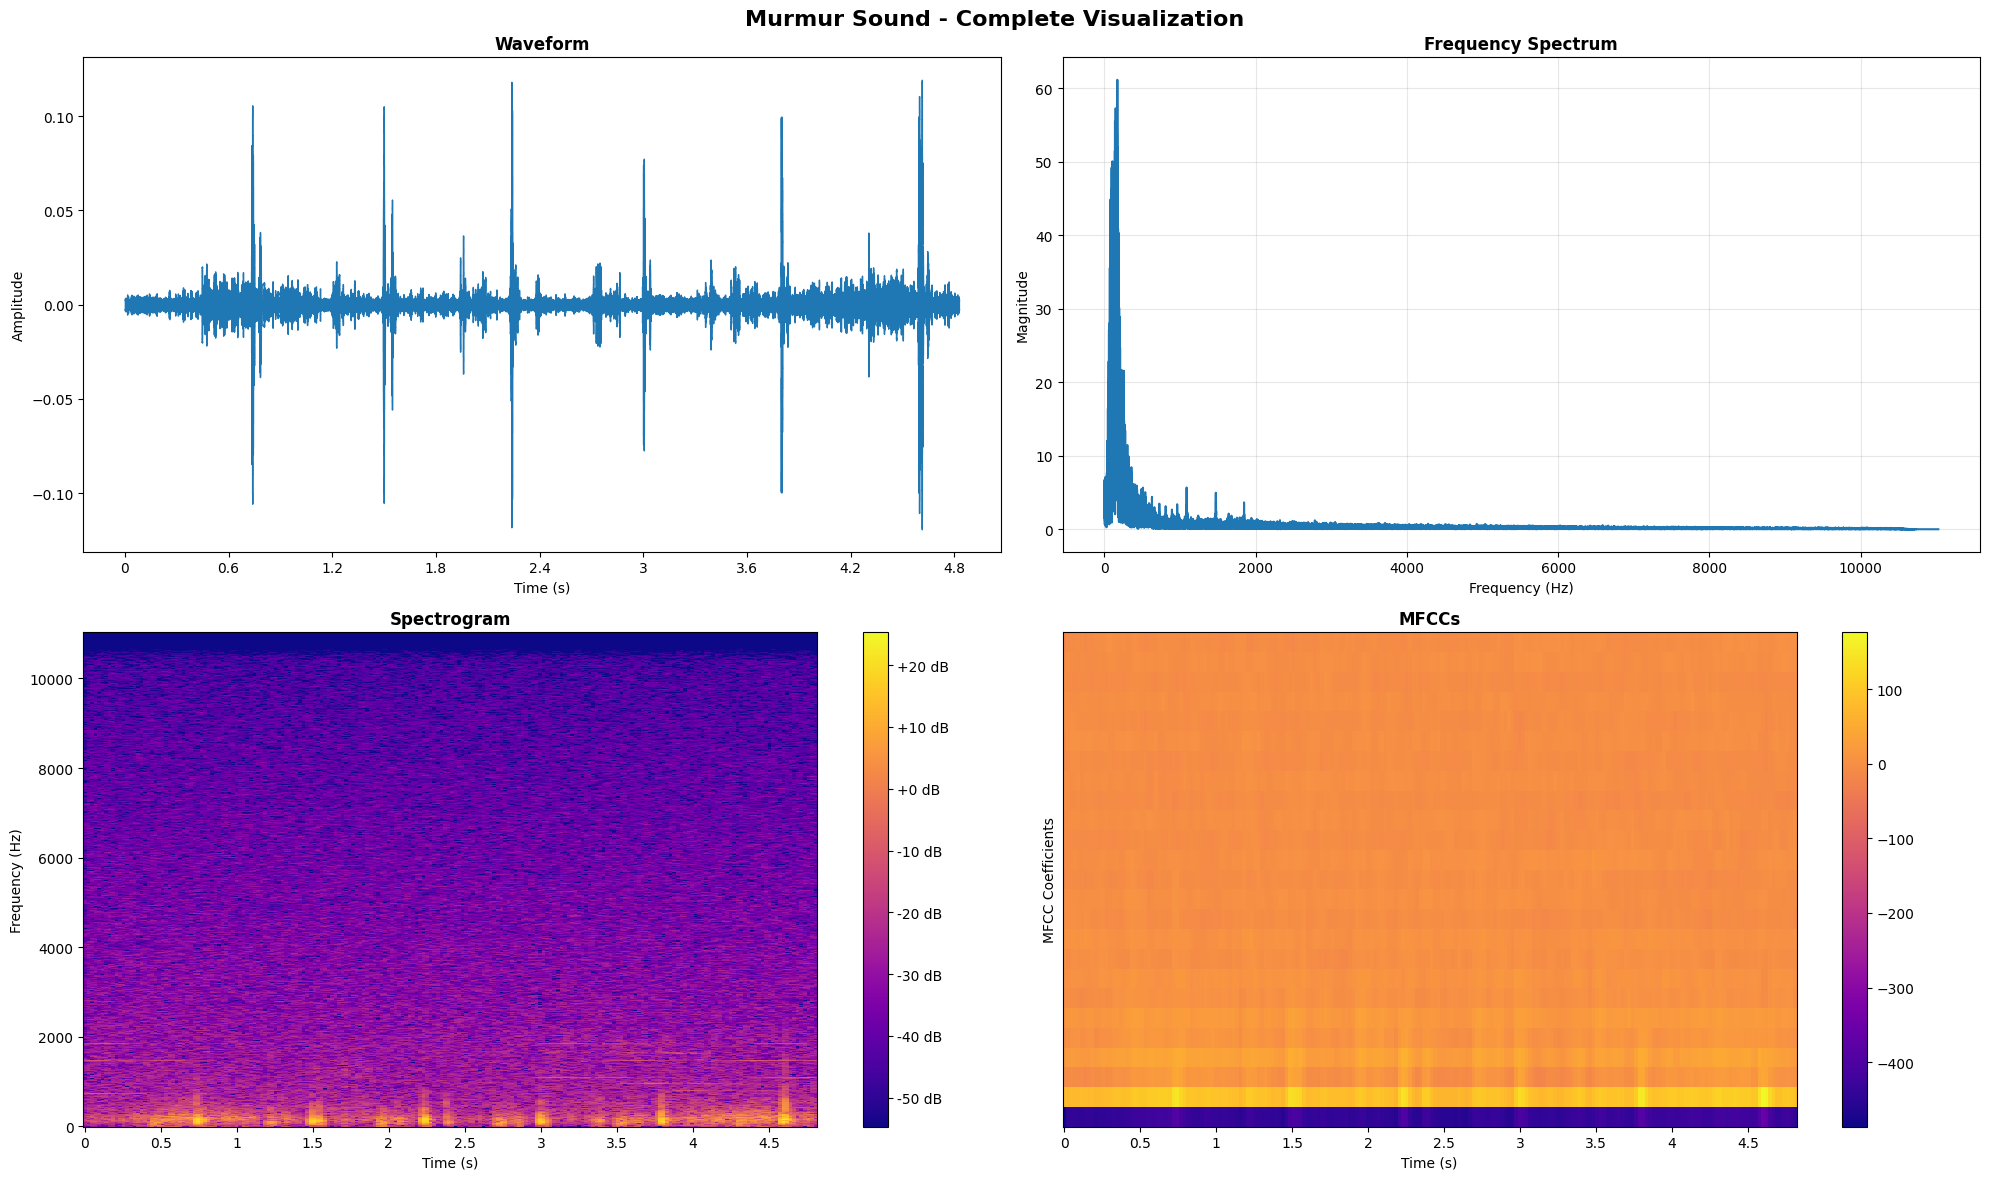

STFT hop length duration: 0.0232s
STFT window duration: 0.0929s


In [9]:
murmur_sample, murmur_sr = visualize_class(murmur_data, "Murmur",
                                           spectrogram_cmap="plasma",
                                           mfcc_cmap="plasma")

###### Extrastole

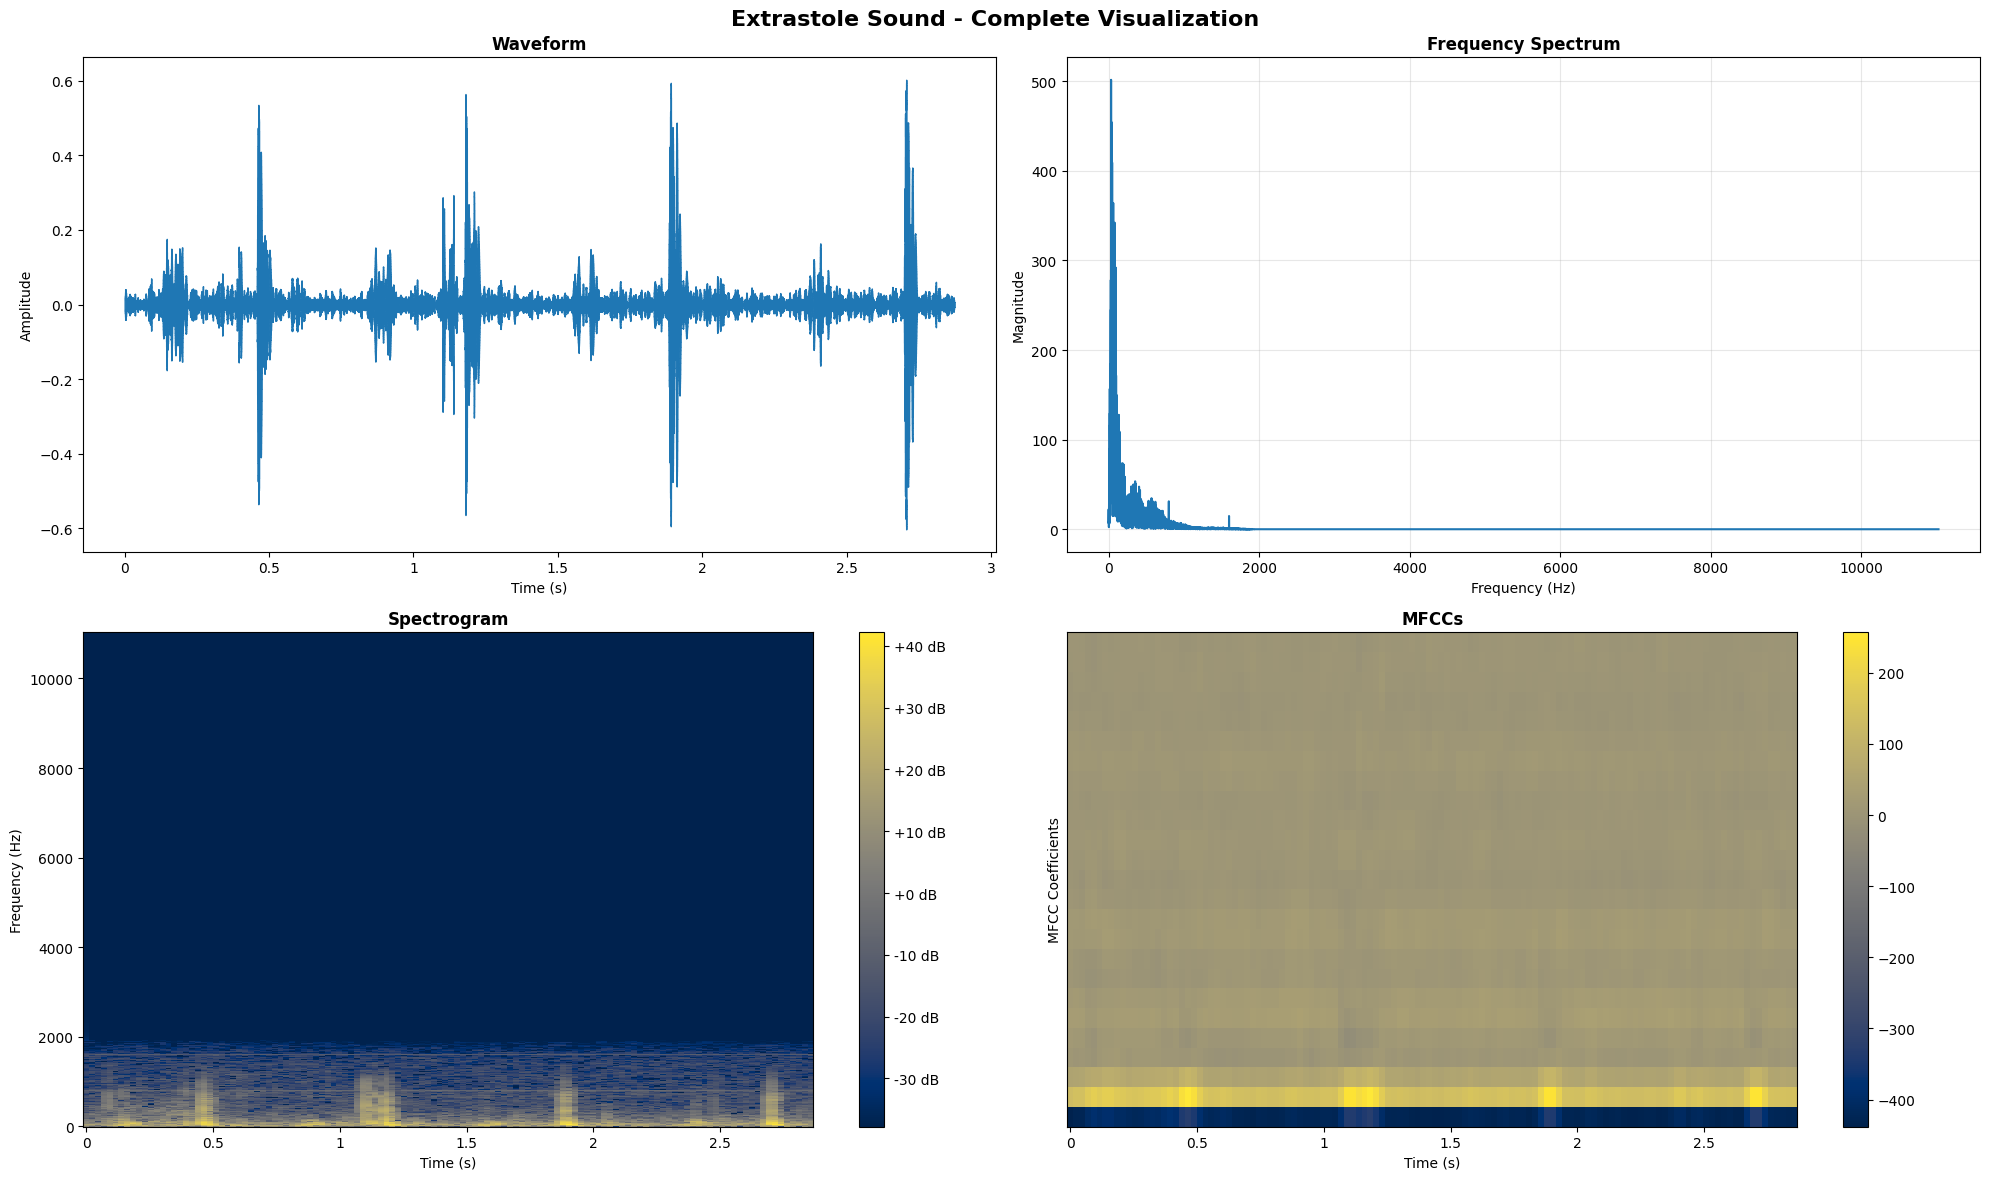

STFT hop length duration: 0.0232s
STFT window duration: 0.0929s


In [10]:
extrastole_sample, extrastole_sr = visualize_class(extrastole_data, "Extrastole",
                                                   spectrogram_cmap="cividis",
                                                   mfcc_cmap="cividis")

###### Artifact

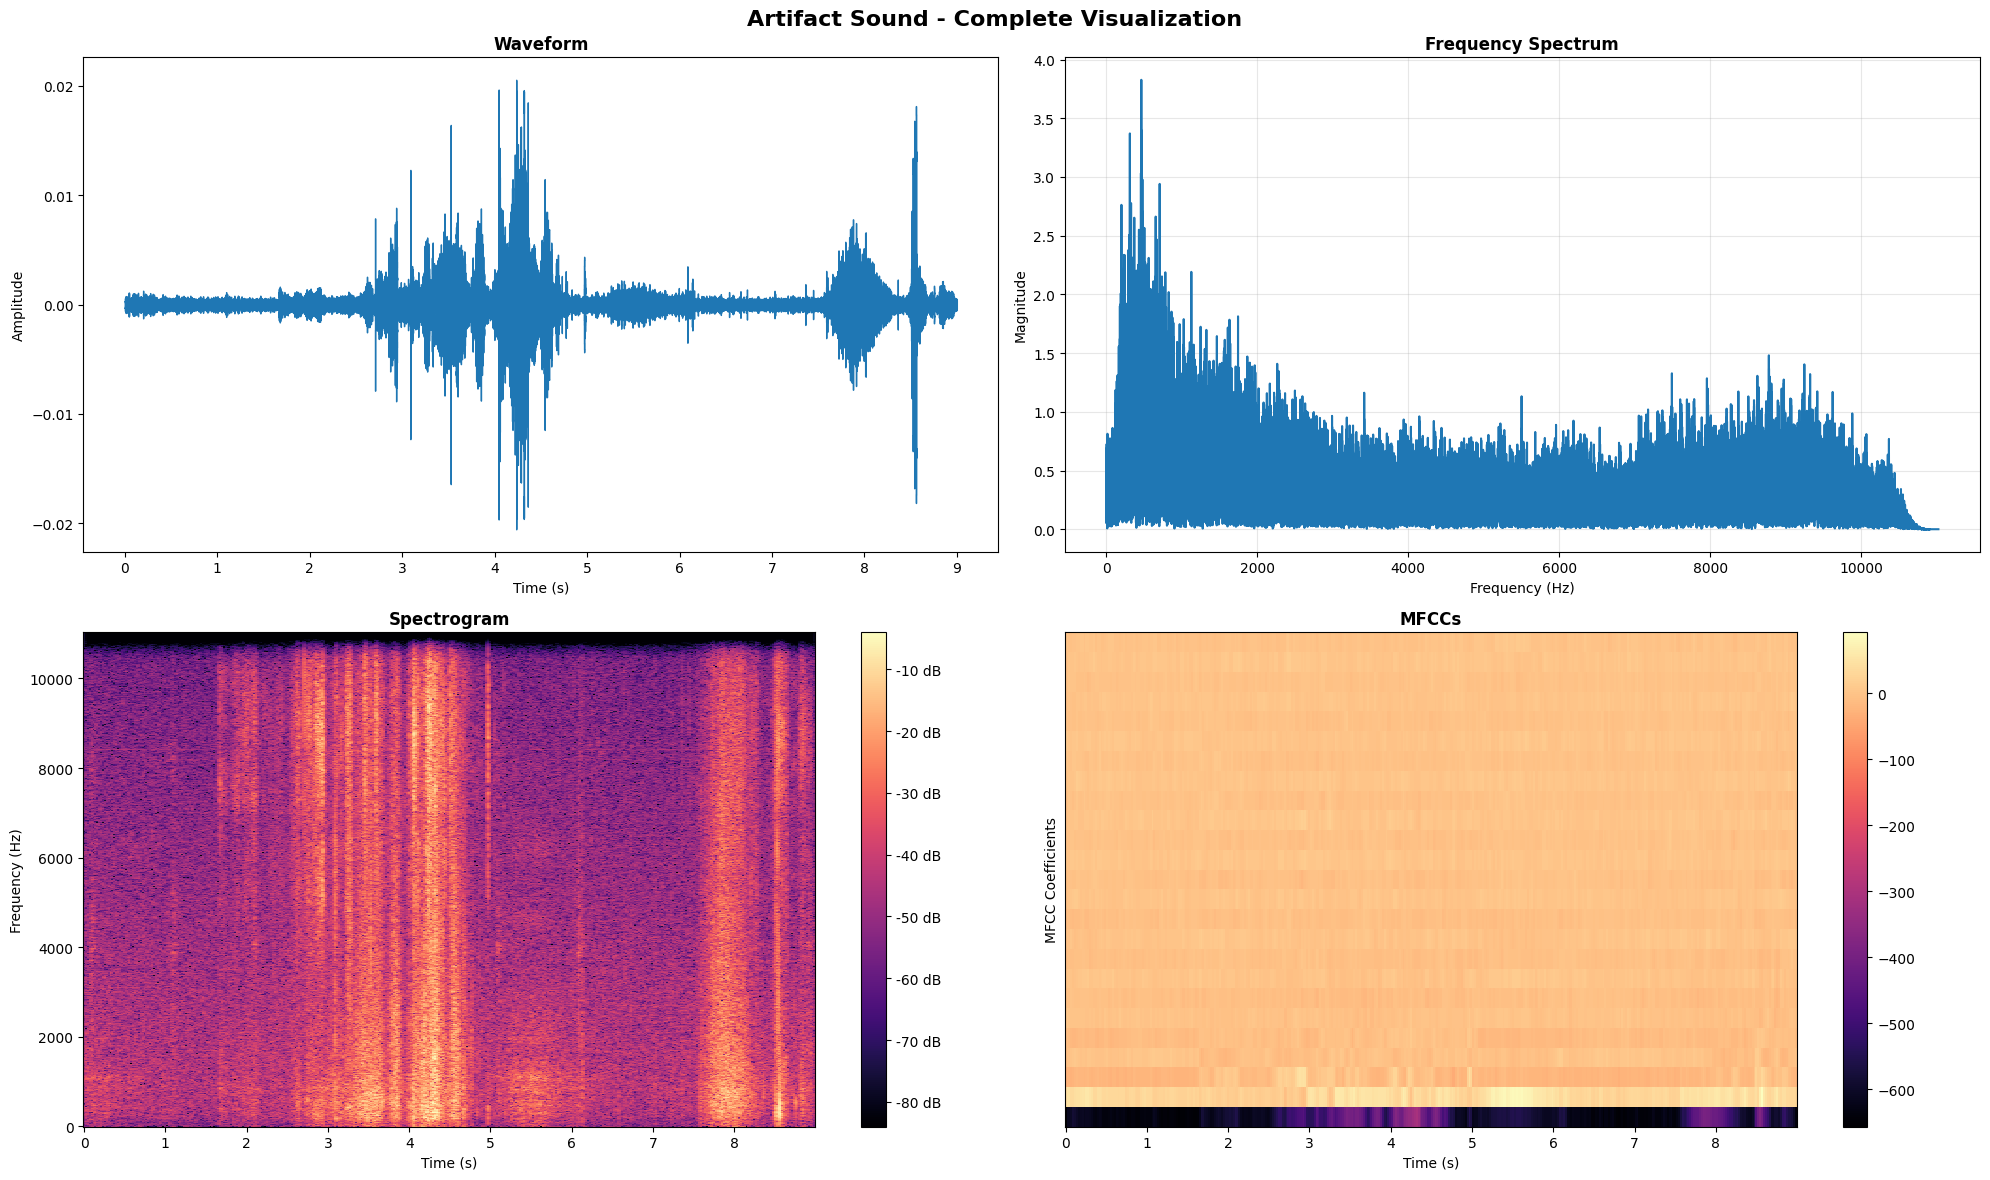

STFT hop length duration: 0.0232s
STFT window duration: 0.0929s


In [11]:
artifact_sample, artifact_sr = visualize_class(artifact_data, "Artifact",
                                               spectrogram_cmap="magma",
                                               mfcc_cmap="magma")

###### Extrahls

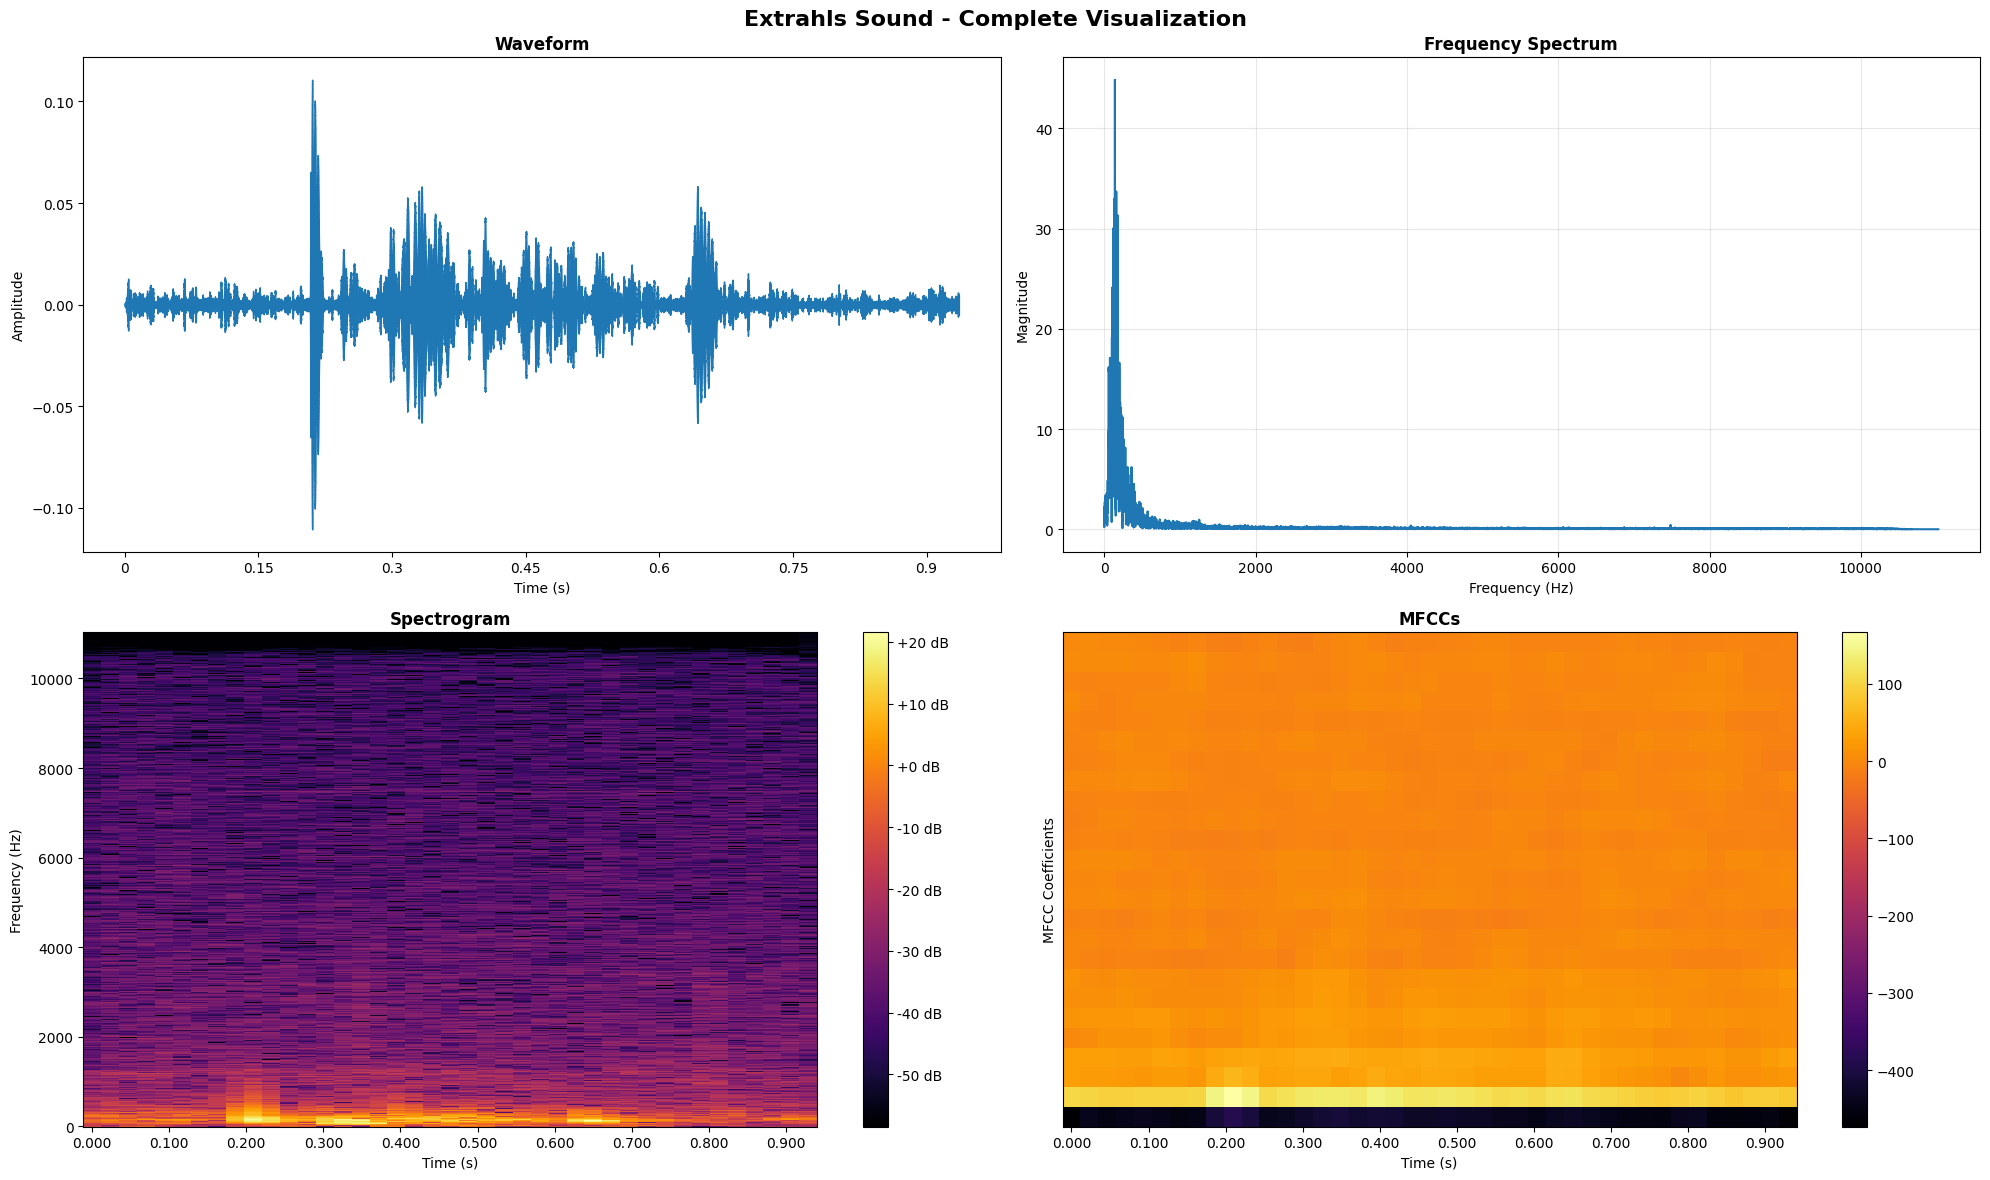

STFT hop length duration: 0.0232s
STFT window duration: 0.0929s


In [12]:
extrahls_sample, extrahls_sr = visualize_class(extrahls_data, "Extrahls",
                                               spectrogram_cmap="inferno",
                                               mfcc_cmap="inferno")

### Klasifikasi

In [13]:
SEED = 42
np.random.seed(SEED)

SAMPLE_RATE = 22050
MAX_SOUND_CLIP_DURATION = 10
N_MFCC = 25 

CLASSES = ['artifact', 'murmur', 'normal', 'extrastole', 'extrahls']
label_to_int = {k: v for v, k in enumerate(CLASSES)}
int_to_label = {v: k for k, v in label_to_int.items()}

In [14]:
# load data

def load_file_data(folder, file_names, duration=MAX_SOUND_CLIP_DURATION, sr=SAMPLE_RATE):
    input_length = sr * duration
    data = []
    for file_name in file_names:
        try:
            sound_file = folder + file_name
            X, sr = librosa.load(sound_file, sr=sr, duration=duration)
            dur = librosa.get_duration(y=X, sr=sr)
            # Pad audio file to same duration
            if (round(dur) < duration):
                y = librosa.util.fix_length(data=X, size=input_length)
            else:
                y = X
            # Extract normalized MFCC feature from data (mean across time)
            mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC).T, axis=0)
        except Exception as e:
            print(f"Error encountered while parsing file: {file_name}")
            print(e)
            continue
        feature = np.array(mfccs).reshape([-1, 1])
        data.append(feature)
    return data

artifact_files = fnmatch.filter(os.listdir(artifact_data), 'artifact*.wav')
artifact_sounds = load_file_data(folder=artifact_data, file_names=artifact_files, duration=MAX_SOUND_CLIP_DURATION)
artifact_labels = [0 for items in artifact_files]

normal_files = fnmatch.filter(os.listdir(normal_data), 'normal*.wav')
normal_sounds = load_file_data(folder=normal_data, file_names=normal_files, duration=MAX_SOUND_CLIP_DURATION)
normal_labels = [2 for items in normal_files]

extrahls_files = fnmatch.filter(os.listdir(extrahls_data), 'extrahls*.wav')
extrahls_sounds = load_file_data(folder=extrahls_data, file_names=extrahls_files, duration=MAX_SOUND_CLIP_DURATION)
extrahls_labels = [4 for items in extrahls_files]

murmur_files = fnmatch.filter(os.listdir(murmur_data), 'murmur*.wav')
murmur_sounds = load_file_data(folder=murmur_data, file_names=murmur_files, duration=MAX_SOUND_CLIP_DURATION)
murmur_labels = [1 for items in murmur_files]

extrastole_files = fnmatch.filter(os.listdir(extrastole_data), 'extrastole*.wav')
extrastole_sounds = load_file_data(folder=extrastole_data, file_names=extrastole_files, duration=MAX_SOUND_CLIP_DURATION)
extrastole_labels = [3 for items in extrastole_files]

In [15]:
# prepare & split data
x_data = np.concatenate((artifact_sounds, normal_sounds, extrahls_sounds, murmur_sounds, extrastole_sounds))
y_data = np.concatenate((artifact_labels, normal_labels, extrahls_labels, murmur_labels, extrastole_labels))

print(f"Total samples: {len(x_data)}")
print("Class distribution:")
for i, class_name in enumerate(CLASSES):
    count = np.sum(y_data == i)
    print(f"  {class_name}: {count}")


x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, random_state=SEED, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8, random_state=SEED, shuffle=True)

print(f"\nTrain set: {len(x_train)} ({len(x_train)/len(x_data)*100:.1f}%)")
print(f"Validation set: {len(x_val)} ({len(x_val)/len(x_data)*100:.1f}%)")
print(f"Test set: {len(x_test)} ({len(x_test)/len(x_data)*100:.1f}%)")

X_train_rf = x_train.reshape((x_train.shape[0], -1))
X_val_rf = x_val.reshape((x_val.shape[0], -1))
X_test_rf = x_test.reshape((x_test.shape[0], -1))

print(f"Feature shapes: Train={X_train_rf.shape}, Val={X_val_rf.shape}, Test={X_test_rf.shape}")
print(f"Number of features per sample: {X_train_rf.shape[1]}")

Total samples: 585
Class distribution:
  artifact: 40
  murmur: 129
  normal: 351
  extrastole: 46
  extrahls: 19

Train set: 374 (63.9%)
Validation set: 94 (16.1%)
Test set: 117 (20.0%)
Feature shapes: Train=(374, 25), Val=(94, 25), Test=(117, 25)
Number of features per sample: 25


In [16]:
# train RF
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,
    class_weight='balanced_subsample',
    random_state=SEED
)

rf.fit(X_train_rf, y_train)

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=400,
                       n_jobs=-1, random_state=42)

In [17]:
# validation performance
val_pred = rf.predict(X_val_rf)
val_acc = accuracy_score(y_val, val_pred)
print(f"RF validation accuracy: {val_acc*100:.2f}%")

# test performance
rf_test_pred = rf.predict(X_test_rf)
rf_test_acc = accuracy_score(y_test, rf_test_pred)
rf_test_f1 = f1_score(y_test, rf_test_pred, average='macro')
print(f"RF test accuracy: {rf_test_acc*100:.2f}%")
print(f"RF test F1-score (macro): {rf_test_f1*100:.2f}%")

print(classification_report(y_test, rf_test_pred, target_names=CLASSES, zero_division=0))

RF validation accuracy: 63.83%
RF test accuracy: 70.94%
RF test F1-score (macro): 55.24%
              precision    recall  f1-score   support

    artifact       1.00      1.00      1.00         8
      murmur       0.88      0.32      0.47        22
      normal       0.68      0.96      0.80        69
  extrastole       0.00      0.00      0.00        14
    extrahls       0.50      0.50      0.50         4

    accuracy                           0.71       117
   macro avg       0.61      0.55      0.55       117
weighted avg       0.65      0.71      0.64       117




CONFUSION MATRIX (Test Set)
[[ 8  0  0  0  0]
 [ 0  7 15  0  0]
 [ 0  1 66  0  2]
 [ 0  0 14  0  0]
 [ 0  0  2  0  2]]


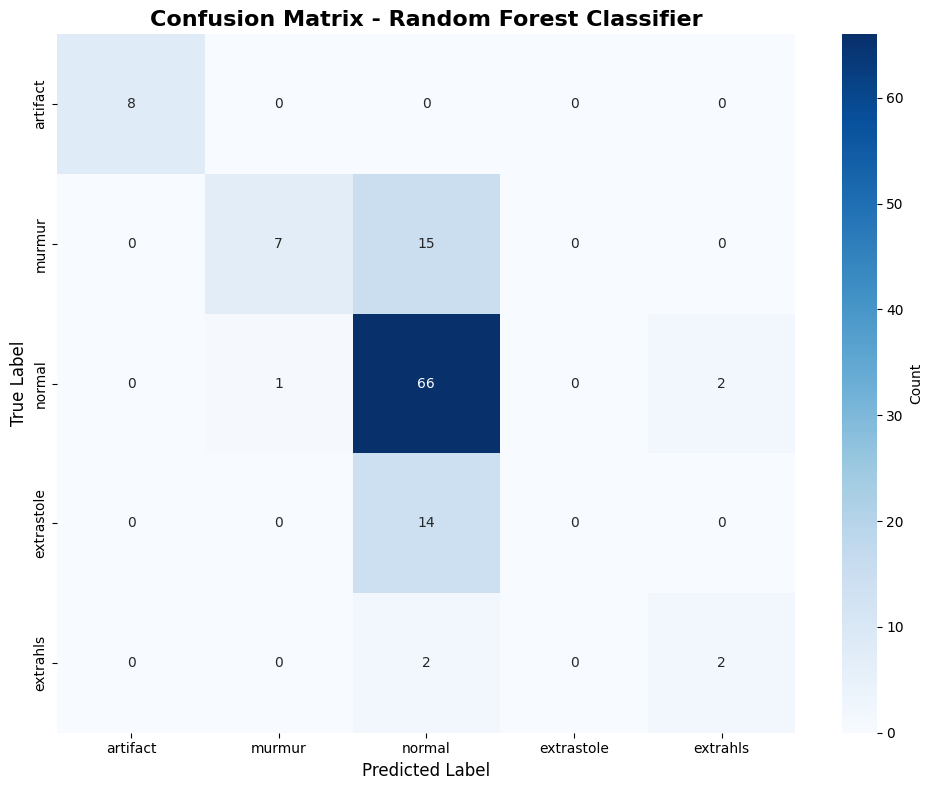

In [18]:
# confusion matrix
cm_rf = confusion_matrix(y_test, rf_test_pred)
print("\n" + "="*70)
print("CONFUSION MATRIX (Test Set)")
print("="*70)
print(cm_rf)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_rf, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=CLASSES,
    yticklabels=CLASSES,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Random Forest Classifier', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

In [19]:
feature_importances = rf.feature_importances_
top_indices = np.argsort(feature_importances)[-10:][::-1]

for i, idx in enumerate(top_indices, 1):
    print(f"{i:2d}. MFCC-{idx:2d}: {feature_importances[idx]:.6f}")

 1. MFCC-10: 0.074219
 2. MFCC- 8: 0.069588
 3. MFCC- 4: 0.061024
 4. MFCC-22: 0.060892
 5. MFCC-14: 0.059630
 6. MFCC-18: 0.055272
 7. MFCC- 6: 0.054925
 8. MFCC- 7: 0.052330
 9. MFCC- 9: 0.051566
10. MFCC-13: 0.041497
